Load packages

In [96]:
from __future__ import annotations
from capymoa.base import AnomalyDetector
from capymoa.instance import Instance, LabelIndex
from capymoa.stream._stream import Schema
from capymoa.type_alias import AnomalyScore
from capymoa.stream import stream_from_file
from capymoa.evaluation import prequential_evaluation_anomaly
from capymoa.evaluation.visualization import plot_windowed_results
from concurrent.futures import ThreadPoolExecutor
from dataclasses import dataclass
from itertools import repeat
from multiprocessing import cpu_count
from numpy import (
    argsort,
    asarray,
    empty,
    finfo,
    inf,
    log,
    ndarray,
    sort,
    split,
    vstack,
    zeros,
    array_split,
    hstack,
    genfromtxt,
    floor,
    unique,
)
from numpy.linalg import norm
from numpy.random import default_rng, Generator, choice, random, uniform
from typing import Literal, Optional, Tuple
from abc import ABC, abstractmethod
from sys import stdout
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.utils import shuffle

Set env var

In [98]:
os.environ["JAVA_HOME"] = "/opt/homebrew/Cellar/openjdk"

CapyMoa OIF implementation

In [97]:
class OnlineIsolationForest(AnomalyDetector):
    """Online Isolation Forest

    This class implements the Online Isolation Forest (oIFOR) algorithm, which is
    an ensemble anomaly detector capable of adapting to concept drift.

    Reference:

    `Online Isolation Forest.
    Filippo Leveni, Guilherme Weigert Cassales, Bernhard Pfahringer, Albert Bifet, and Giacomo Boracchi.
    International Conference on Machine Learning (ICML), Proceedings of Machine Learning Research (PMLR), 2024.
    <https://proceedings.mlr.press/v235/leveni24a.html>`_

    Example:

    >>> from capymoa.datasets import ElectricityTiny
    >>> from capymoa.anomaly import OnlineIsolationForest
    >>> from capymoa.evaluation import AnomalyDetectionEvaluator
    >>> stream = ElectricityTiny()
    >>> schema = stream.get_schema()
    >>> learner = OnlineIsolationForest(schema=schema)
    >>> evaluator = AnomalyDetectionEvaluator(schema)
    >>> while stream.has_more_instances():
    ...     instance = stream.next_instance()
    ...     proba = learner.score_instance(instance)
    ...     evaluator.update(instance.y_index, proba)
    ...     learner.train(instance)
    >>> auc = evaluator.auc()
    >>> print(f"AUC: {auc:.2f}")
    AUC: 0.52

    """

    def __init__(
        self,
        schema: Optional[Schema] = None,
        random_seed: int = 1,
        num_trees: int = 32,
        max_leaf_samples: int = 32,
        growth_criterion: Literal["fixed", "adaptive"] = "adaptive",
        subsample: float = 1.0,
        window_size: int = 2048,
        branching_factor: int = 2,
        split: Literal["axisparallel"] = "axisparallel",
        n_jobs: int = 1,
    ):
        """Construct an Online Isolation Forest anomaly detector

        :param schema: The schema of the stream. If not provided, it will be inferred from the data.
        :param random_seed: Random seed for reproducibility.
        :param num_trees: Number of trees in the ensemble.
        :param window_size: The size of the window for each tree.
        :param branching_factor: Branching factor of each tree.
        :param max_leaf_samples: Maximum number of samples per leaf. When this number is reached, a split is performed.
        :param growth_criterion: When to perform a split. If 'adaptive', the max_leaf_samples grows with tree depth,
                                 otherwise 'fixed'.
        :param subsample: Probability of learning a new sample in each tree.
        :param split: Type of split performed at each node. Currently only 'axisparallel' is supported, which is the
                      same type used by the IsolationForest algorithm.
        :param n_jobs: Number of parallel jobs.
        """
        super().__init__(schema=schema, random_seed=random_seed)
        self.num_trees: int = num_trees
        self.window_size: int = window_size
        self.branching_factor: int = branching_factor
        self.max_leaf_samples: int = max_leaf_samples
        self.growth_criterion: Literal["fixed", "adaptive"] = growth_criterion
        self.subsample: float = subsample
        self.trees: list[OnlineIsolationTree] = []
        self.data_window: list[ndarray] = []
        self.data_size: int = 0
        self.normalization_factor: float = 0
        self.split: Literal["axisparallel"] = split
        self.n_jobs: int = cpu_count() if n_jobs == -1 else min(n_jobs, cpu_count())
        self.random_generator: Generator = default_rng(
            seed=random_seed
        )  # Use RNG to generate random seeds for each tree
        self.random_seeds: list = [
            self.random_generator.integers(0, 2**32) for _ in range(self.num_trees)
        ]
        self.trees: list[OnlineIsolationTree] = [
            OnlineIsolationTree(
                max_leaf_samples=max_leaf_samples,
                growth_criterion=growth_criterion,
                subsample=self.subsample,
                branching_factor=self.branching_factor,
                data_size=self.data_size,
                split=self.split,
                random_seed=self.random_seeds[i],
            )
            for i in range(self.num_trees)
        ]

    def train(self, instance: Instance):
        data: ndarray = instance.x.reshape((1, -1))
        self._learn_batch(data)
        return

    def __str__(self):
        return "Online Isolation Forest"

    def predict(self, instance: Instance) -> Optional[LabelIndex]:
        pass

    def score_instance(self, instance: Instance) -> AnomalyScore:
        data: ndarray = instance.x.reshape((1, -1))
        return self._score_batch(data)[0]

    def _learn_batch(self, data: ndarray) -> OnlineIsolationForest:
        # Update the counter of data seen so far
        self.data_size += data.shape[0]
        # Compute the normalization factor
        self.normalization_factor: float = OnlineIsolationTree._get_random_path_length(
            self.branching_factor,
            self.max_leaf_samples,
            self.data_size * self.subsample,
        )
        # Instantiate a list of OnlineIsolationTrees' learn functions
        learn_funcs: list["function"] = [tree._learn for tree in self.trees]
        # OnlineIsolationTrees learn new data
        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            self.trees: list[OnlineIsolationTree] = list(
                executor.map(
                    lambda f, x: f(x), learn_funcs, repeat(data, self.num_trees)
                )
            )
        # If the window size is not None, add new data to the window and eventually remove old ones
        if self.window_size:
            # Update the window of data seen so far
            self.data_window += list(data)
            # If the window size is smaller than the number of data seen so far, unlearn old data
            if self.data_size > self.window_size:
                # Extract old data and update the window of data seen so far
                data, self.data_window = (
                    asarray(self.data_window[: self.data_size - self.window_size]),
                    self.data_window[self.data_size - self.window_size :],
                )
                # Update the counter of data seen so far
                self.data_size -= self.data_size - self.window_size
                # Compute the normalization factor
                self.normalization_factor: float = (
                    OnlineIsolationTree._get_random_path_length(
                        self.branching_factor,
                        self.max_leaf_samples,
                        self.data_size * self.subsample,
                    )
                )
                # Instantiate a list of OnlineIsolationTrees' unlearn functions
                unlearn_funcs: list["function"] = [tree._unlearn for tree in self.trees]
                # OnlineIsolationTrees unlearn new data
                with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
                    self.trees: list[OnlineIsolationTree] = list(
                        executor.map(
                            lambda f, x: f(x),
                            unlearn_funcs,
                            repeat(data, self.num_trees),
                        )
                    )
        return self

    def _score_batch(self, data: ndarray) -> ndarray[float]:
        # Collect OnlineIsolationTrees' predict functions
        predict_funcs: list["function"] = [tree._predict for tree in self.trees]
        # Compute the depths of all samples in each tree
        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            depths: ndarray[float] = asarray(
                list(
                    executor.map(
                        lambda f, x: f(x), predict_funcs, repeat(data, self.num_trees)
                    )
                )
            ).T
        # Compute the mean depth of each sample along all trees
        mean_depths: ndarray[float] = depths.mean(axis=1)
        # Compute normalized mean depths
        normalized_mean_depths: ndarray[float] = 2 ** (
            -mean_depths / (self.normalization_factor + finfo(float).eps)
        )
        return normalized_mean_depths


class OnlineIsolationTree:
    def __init__(
        self,
        max_leaf_samples: int,
        growth_criterion: Literal["fixed", "adaptive"],
        subsample: float,
        branching_factor: int,
        data_size: int,
        split: Literal["axisparallel"] = "axisparallel",
        random_seed: int = 1,
    ):
        self.max_leaf_samples: int = max_leaf_samples
        self.growth_criterion: Literal["fixed", "adaptive"] = growth_criterion
        self.subsample: float = subsample
        self.branching_factor: int = branching_factor
        self.data_size: int = data_size
        self.split: Literal["axisparallel"] = split
        self.random_generator: Generator = default_rng(seed=random_seed)
        self.depth_limit: float = OnlineIsolationTree._get_random_path_length(
            self.branching_factor,
            self.max_leaf_samples,
            self.data_size * self.subsample,
        )
        self.root: Optional[OnlineIsolationNode] = None
        self.next_node_index: int = 0

    @staticmethod
    def _get_random_path_length(
        branching_factor: int, max_leaf_samples: int, num_samples: float
    ) -> float:
        if num_samples < max_leaf_samples:
            return 0
        else:
            return log(num_samples / max_leaf_samples) / log(2 * branching_factor)

    @staticmethod
    def _get_multiplier(
        growth_criterion: Literal["fixed", "adaptive"], depth: int
    ) -> int:
        # Compute the multiplier according to the growth criterion
        if growth_criterion == "fixed":
            return 1
        elif growth_criterion == "adaptive":
            return 2**depth
        else:
            raise ValueError("Bad grow criterion {}".format(growth_criterion))

    @staticmethod
    def _split_data(
        data: ndarray, projection_vector: ndarray[float], split_values: ndarray[float]
    ) -> list[ndarray[int]]:
        # Project data using projection vector
        projected_data: ndarray = data @ projection_vector
        # Sort projected data and keep sort indices
        sort_indices: ndarray = argsort(projected_data)
        # Split data according to their membership
        partition: list[ndarray[int]] = split(
            sort_indices, projected_data[sort_indices].searchsorted(split_values)
        )
        return partition

    def _learn(self, data: ndarray) -> OnlineIsolationTree:
        # Subsample data in order to improve diversity among trees
        data: ndarray = data[
            self.random_generator.random(data.shape[0]) < self.subsample
        ]
        if data.shape[0] >= 1:
            # Update the counter of data seen so far
            self.data_size += data.shape[0]
            # Adjust depth limit according to data seen so far and branching factor
            self.depth_limit: float = OnlineIsolationTree._get_random_path_length(
                self.branching_factor, self.max_leaf_samples, self.data_size
            )
            # Recursively update the tree
            self.next_node_index, self.root = (
                self._recursive_build(data)
                if self.root is None
                else self._recursive_learn(self.root, data, self.next_node_index)
            )
        return self

    def _recursive_learn(
        self, node: OnlineIsolationNode, data: ndarray, node_index: int
    ) -> Tuple[int, OnlineIsolationNode]:
        # Update the number of data seen so far by the current node
        node.data_size += data.shape[0]
        # Update the vectors of minimum and maximum values seen so far by the current node
        node.min_values: ndarray = vstack([data, node.min_values]).min(axis=0)
        node.max_values: ndarray = vstack([data, node.max_values]).max(axis=0)
        # If the current node is a leaf, try to split it
        if node.children is None:
            # If there are enough samples to be split according to the max leaf samples and the depth limit has not been
            # reached yet, split the node
            if (
                node.data_size
                >= self.max_leaf_samples
                * OnlineIsolationTree._get_multiplier(self.growth_criterion, node.depth)
                and node.depth < self.depth_limit
            ):
                # Sample data_size points uniformly at random within the bounding box defined by the vectors of minimum
                # and maximum values of data seen so far by the current node
                data_sampled: ndarray = self.random_generator.uniform(
                    node.min_values,
                    node.max_values,
                    size=(node.data_size, data.shape[1]),
                )
                return self._recursive_build(
                    data_sampled, depth=node.depth, node_index=node_index
                )
            else:
                return node_index, node
        # If the current node is not a leaf, recursively update all its children
        else:
            # Partition data
            partition_indices: list[ndarray[int]] = self._split_data(
                data, node.projection_vector, node.split_values
            )
            # Recursively update children
            for i, indices in enumerate(partition_indices):
                node_index, node.children[i] = self._recursive_learn(
                    node.children[i], data[indices], node_index
                )
            return node_index, node

    def _recursive_build(
        self, data: ndarray, depth: int = 0, node_index: int = 0
    ) -> Tuple[int, OnlineIsolationNode]:
        # If there aren't enough samples to be split according to the max leaf samples or the depth limit has been
        # reached, build a leaf node
        if (
            data.shape[0]
            < self.max_leaf_samples
            * OnlineIsolationTree._get_multiplier(self.growth_criterion, depth)
            or depth >= self.depth_limit
        ):
            return node_index + 1, OnlineIsolationNode(
                data_size=data.shape[0],
                children=None,
                depth=depth,
                node_index=node_index,
                min_values=data.min(axis=0, initial=inf),
                max_values=data.max(axis=0, initial=-inf),
                projection_vector=None,
                split_values=None,
            )
        else:
            # Sample projection vector
            if self.split == "axisparallel":
                projection_vector: ndarray[float] = zeros(data.shape[1])
                projection_vector[
                    self.random_generator.choice(projection_vector.shape[0])
                ]: float = 1.0
            else:
                raise ValueError("Bad split {}".format(self.split))
            projection_vector: ndarray[float] = projection_vector / norm(
                projection_vector
            )
            # Project sampled data using projection vector
            projected_data: ndarray = data @ projection_vector
            # Sample split values
            split_values: ndarray[float] = sort(
                self.random_generator.uniform(
                    min(projected_data),
                    max(projected_data),
                    size=self.branching_factor - 1,
                )
            )
            # Partition sampled data
            partition_indices: list[ndarray[int]] = self._split_data(
                data, projection_vector, split_values
            )
            # Generate recursively children nodes
            children: ndarray[OnlineIsolationNode] = empty(
                shape=(self.branching_factor,), dtype=OnlineIsolationNode
            )
            for i, indices in enumerate(partition_indices):
                node_index, children[i] = self._recursive_build(
                    data[indices], depth + 1, node_index
                )
            return node_index + 1, OnlineIsolationNode(
                data_size=data.shape[0],
                children=children,
                depth=depth,
                node_index=node_index,
                min_values=data.min(axis=0),
                max_values=data.max(axis=0),
                projection_vector=projection_vector,
                split_values=split_values,
            )

    def _unlearn(self, data: ndarray) -> OnlineIsolationTree:
        # Subsample data in order to improve diversity among trees
        data: ndarray = data[
            self.random_generator.random(data.shape[0]) < self.subsample
        ]
        if data.shape[0] >= 1:
            # Update the counter of data seen so far
            self.data_size -= data.shape[0]
            # Adjust depth limit according to data seen so far and branching factor
            self.depth_limit: float = OnlineIsolationTree._get_random_path_length(
                self.branching_factor, self.max_leaf_samples, self.data_size
            )
            # Recursively update the tree
            self.root: OnlineIsolationNode = self._recursive_unlearn(self.root, data)
        return self

    def _recursive_unlearn(
        self, node: OnlineIsolationNode, data: ndarray
    ) -> OnlineIsolationNode:
        # Update the number of data seen so far by the current node
        node.data_size -= data.shape[0]
        # If the current node is a leaf, return it
        if node.children is None:
            return node
        # If the current node is not a leaf, try to unsplit it
        else:
            # If there are not enough samples according to max leaf samples, unsplit the node
            if (
                node.data_size
                < self.max_leaf_samples
                * OnlineIsolationTree._get_multiplier(self.growth_criterion, node.depth)
            ):
                return self._recursive_unbuild(node)
            # If there are enough samples according to max leaf samples, recursively update all its children
            else:
                # Partition data
                partition_indices: list[ndarray[int]] = self._split_data(
                    data, node.projection_vector, node.split_values
                )
                # Recursively update children
                for i, indices in enumerate(partition_indices):
                    node.children[i]: OnlineIsolationNode = self._recursive_unlearn(
                        node.children[i], data[indices]
                    )
                # Update the vectors of minimum and maximum values seen so far by the current node
                node.min_values: ndarray = vstack(
                    [node.children[i].min_values for i, _ in enumerate(node.children)]
                ).min(axis=0)
                node.max_values: ndarray = vstack(
                    [node.children[i].max_values for i, _ in enumerate(node.children)]
                ).max(axis=0)
                return node

    def _recursive_unbuild(self, node: OnlineIsolationNode) -> OnlineIsolationNode:
        # If the current node is a leaf, return it
        if node.children is None:
            return node
        # If the current node is not a leaf, unbuild it
        else:
            # Recursively unbuild children
            for i, _ in enumerate(node.children):
                node.children[i]: OnlineIsolationNode = self._recursive_unbuild(
                    node.children[i]
                )
            # Update the vectors of minimum and maximum values seen so far by the current node
            node.min_values: ndarray = vstack(
                [node.children[i].min_values for i, _ in enumerate(node.children)]
            ).min(axis=0)
            node.max_values: ndarray = vstack(
                [node.children[i].max_values for i, _ in enumerate(node.children)]
            ).max(axis=0)
            # Delete children nodes, projection vector and split values
            node.children: Optional[ndarray[OnlineIsolationNode]] = None
            node.projection_vector: Optional[ndarray[float]] = None
            node.split_values: Optional[ndarray[float]] = None
            return node

    def _predict(self, data: ndarray) -> ndarray[float]:
        # Compute depth of each sample
        if self.root:
            return self._recursive_depth_search(
                self.root, data, empty(shape=(data.shape[0],), dtype=float)
            )
        else:
            return zeros(shape=(data.shape[0],), dtype=float)

    def _recursive_depth_search(
        self, node: OnlineIsolationNode, data: ndarray, depths: ndarray[float]
    ) -> ndarray[float]:
        # If the current node is a leaf, fill the depths vector with the current depth plus a normalization factor
        if node.children is None or data.shape[0] == 0:
            depths[:] = node.depth + OnlineIsolationTree._get_random_path_length(
                self.branching_factor, self.max_leaf_samples, node.data_size
            )
        else:
            # Partition data
            partition_indices: list[ndarray[int]] = self._split_data(
                data, node.projection_vector, node.split_values
            )
            # Fill the vector of depths
            for i, indices in enumerate(partition_indices):
                depths[indices]: ndarray[float] = self._recursive_depth_search(
                    node.children[i], data[indices], depths[indices]
                )
        return depths


@dataclass
class OnlineIsolationNode:
    def __init__(
        self,
        data_size: int,
        children: Optional[ndarray[OnlineIsolationNode]],
        depth: int,
        node_index: int,
        min_values: ndarray,
        max_values: ndarray,
        projection_vector: Optional[ndarray[float]],
        split_values: Optional[ndarray[float]],
    ):
        self.data_size: int = data_size
        self.children: Optional[ndarray[OnlineIsolationNode]] = children
        self.depth: int = depth
        self.node_index: int = node_index
        self.min_values: ndarray = min_values
        self.max_values: ndarray = max_values
        self.projection_vector: Optional[ndarray[float]] = projection_vector
        self.split_values: Optional[ndarray[float]] = split_values


Original OIF implementation

In [99]:
class OnlineIForest(ABC):
    @staticmethod
    def create(
        iforest_type: str = "boundedrandomprojectiononlineiforest", **kwargs
    ) -> "OnlineIForest":
        # TODO: Find an alternative solution to overcome circular imports
        # Map iforest type to an iforest class
        iforest_type_to_iforest_map: dict = {
            "boundedrandomprojectiononlineiforest": BoundedRandomProjectionOnlineIForest
        }
        if iforest_type not in iforest_type_to_iforest_map:
            raise ValueError("Bad iforest type {}".format(iforest_type))
        return iforest_type_to_iforest_map[iforest_type](**kwargs)

    def __init__(
        self,
        num_trees: int,
        window_size: int,
        branching_factor: int,
        max_leaf_samples: int,
        type: str,
        subsample: float,
        n_jobs: int,
    ):
        self.num_trees: int = num_trees
        self.window_size: int = window_size
        self.branching_factor: int = branching_factor
        self.max_leaf_samples: int = max_leaf_samples
        self.type: str = type
        self.subsample: float = subsample
        self.trees: list[OnlineITree] = []
        self.data_window: list[ndarray] = []
        self.data_size: int = 0
        self.normalization_factor: float = None
        self.n_jobs: int = cpu_count() if n_jobs == -1 else min(n_jobs, cpu_count())

    @abstractmethod
    def learn_batch(self, data: ndarray):
        pass

    @abstractmethod
    def score_batch(self, data: ndarray):
        pass

    @abstractmethod
    def predict_batch(self, data: ndarray):
        pass


class OnlineITree(ABC):
    @staticmethod
    def create(itree_type: str, **kwargs) -> "OnlineITree":
        # TODO: Find an alternative solution to overcome circular imports
        # Map itree type to an itree class
        itree_type_to_itree_map: dict = {
            "boundedrandomprojectiononlineitree": BoundedRandomProjectionOnlineITree
        }
        if itree_type not in itree_type_to_itree_map:
            raise ValueError("Bad itree type {}".format(itree_type))
        return itree_type_to_itree_map[itree_type](**kwargs)

    @staticmethod
    def get_random_path_length(
        branching_factor: int, max_leaf_samples: int, num_samples: float
    ) -> float:
        if num_samples < max_leaf_samples:
            return 0
        else:
            return log(num_samples / max_leaf_samples) / log(2 * branching_factor)

    @staticmethod
    def get_multiplier(type: str, depth: int) -> int:
        # Compute the multiplier according to the type
        if type == "fixed":
            return 1
        elif type == "adaptive":
            return 2**depth
        else:
            raise ValueError("Bad type {}".format(type))

    def __init__(
        self,
        max_leaf_samples: int,
        type: str,
        subsample: float,
        branching_factor: int,
        data_size: int,
    ):
        self.max_leaf_samples: int = max_leaf_samples
        self.type: str = type
        self.subsample: float = subsample
        self.branching_factor: int = branching_factor
        self.data_size: int = data_size
        self.depth_limit: float = OnlineITree.get_random_path_length(
            self.branching_factor,
            self.max_leaf_samples,
            self.data_size * self.subsample,
        )
        self.root: OnlineINode = None
        self.next_node_index: int = 0

    @abstractmethod
    def learn(self, data: ndarray) -> "OnlineITree":
        pass

    @abstractmethod
    def recursive_learn(
        self, node: OnlineINode, data: ndarray, node_index: int
    ) -> (int, OnlineINode):
        pass

    @abstractmethod
    def recursive_build(
        self, data: ndarray, depths: ndarray[float], node_index: int
    ) -> (int, OnlineINode):
        pass

    @abstractmethod
    def unlearn(self, data: ndarray) -> "OnlineITree":
        pass

    @abstractmethod
    def recursive_unlearn(self, node: OnlineINode, data: ndarray) -> OnlineINode:
        pass

    @abstractmethod
    def recursive_unbuild(self, node: OnlineINode) -> OnlineINode:
        pass

    @abstractmethod
    def predict(self, data: ndarray) -> ndarray[float]:
        pass

    @abstractmethod
    def recursive_depth_search(
        self, node: OnlineINode, data: ndarray, depths: ndarray[float]
    ) -> ndarray[float]:
        pass

    @abstractmethod
    def split_data(self, data: ndarray, **kwargs) -> list[ndarray[int]]:
        pass


class OnlineINode(ABC):
    @staticmethod
    def create(inode_type: str, **kwargs) -> "OnlineINode":
        # TODO: Find an alternative solution to overcome circular imports
        # Map inode type to an inode class
        inode_type_to_inode_map: dict = {
            "boundedrandomprojectiononlineinode": BoundedRandomProjectionOnlineINode
        }
        if inode_type not in inode_type_to_inode_map:
            raise ValueError("Bad inode type {}".format(inode_type))
        return inode_type_to_inode_map[inode_type](**kwargs)

    def __init__(
        self,
        data_size: int,
        children: ndarray["OnlineINode"],
        depth: int,
        node_index: int,
    ):
        self.data_size: int = data_size
        self.children: ndarray["OnlineINode"] = children
        self.depth: int = depth
        self.node_index: int = node_index


class BoundedRandomProjectionOnlineIForest(OnlineIForest):
    def __init__(
        self,
        num_trees: int = 100,
        max_leaf_samples: int = 32,
        type: str = "adaptive",
        subsample: float = 1.0,
        window_size: int = 2048,
        branching_factor: int = 2,
        metric: str = "axisparallel",
        n_jobs: int = 1,
    ):
        super().__init__(
            num_trees,
            window_size,
            branching_factor,
            max_leaf_samples,
            type,
            subsample,
            n_jobs,
        )
        self.metric: str = metric
        self.trees: list[OnlineITree] = [
            OnlineITree.create(
                "boundedrandomprojectiononlineitree",
                max_leaf_samples=max_leaf_samples,
                type=type,
                subsample=self.subsample,
                branching_factor=self.branching_factor,
                data_size=self.data_size,
                metric=self.metric,
            )
            for _ in range(self.num_trees)
        ]

    def learn_batch(self, data: ndarray) -> "BoundedRandomProjectionOnlineIForest":
        # Update the counter of data seen so far
        self.data_size += data.shape[0]
        # Compute the normalization factor
        self.normalization_factor: float = OnlineITree.get_random_path_length(
            self.branching_factor,
            self.max_leaf_samples,
            self.data_size * self.subsample,
        )
        # Instantiate a list of ITrees' learn functions
        learn_funcs: list["function"] = [tree.learn for tree in self.trees]
        # BoundedRandomProjection OnlineITrees learn new data
        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            self.trees: list[OnlineITree] = list(
                tqdm(
                    executor.map(
                        lambda f, x: f(x), learn_funcs, repeat(data, self.num_trees)
                    ),
                    total=self.num_trees,
                    desc="     BoundedRandomProjection Online Isolation Forest -> Learn Batch",
                    file=stdout,
                    disable=True,
                )
            )
        # If the window size is not None, add new data to the window and eventually remove old ones
        if self.window_size:
            # Update the window of data seen so far
            self.data_window += list(data)
            # If the window size is smaller than the number of data seen so far, unlearn old data
            if self.data_size > self.window_size:
                # Extract old data and update the window of data seen so far
                data, self.data_window = (
                    asarray(self.data_window[: self.data_size - self.window_size]),
                    self.data_window[self.data_size - self.window_size :],
                )
                # Update the counter of data seen so far
                self.data_size -= self.data_size - self.window_size
                # Compute the normalization factor
                self.normalization_factor: float = OnlineITree.get_random_path_length(
                    self.branching_factor,
                    self.max_leaf_samples,
                    self.data_size * self.subsample,
                )
                # Instantiate a list of ITrees' unlearn functions
                unlearn_funcs: list["function"] = [tree.unlearn for tree in self.trees]
                # BoundedRandomProjection OnlineITrees unlearn new data
                with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
                    self.trees: list[OnlineITree] = list(
                        tqdm(
                            executor.map(
                                lambda f, x: f(x),
                                unlearn_funcs,
                                repeat(data, self.num_trees),
                            ),
                            total=self.num_trees,
                            desc="     BoundedRandomProjection Online Isolation Forest -> Unlearn Batch",
                            file=stdout,
                            disable=True,
                        )
                    )
        return self

    def score_batch(self, data: ndarray) -> ndarray[float]:
        # Collect ITrees' predict functions
        predict_funcs: list["function"] = [tree.predict for tree in self.trees]
        # Compute the depths of all samples in each tree
        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            depths: ndarray[float] = asarray(
                list(
                    tqdm(
                        executor.map(
                            lambda f, x: f(x),
                            predict_funcs,
                            repeat(data, self.num_trees),
                        ),
                        total=self.num_trees,
                        desc="     BoundedRandomProjection Online Isolation Forest -> Score Batch",
                        file=stdout,
                        disable=True,
                    )
                )
            ).T
        # Compute the mean depth of each sample along all trees
        mean_depths: ndarray[float] = depths.mean(axis=1)
        # Compute normalized mean depths
        normalized_mean_depths: ndarray[float] = 2 ** (
            -mean_depths / (self.normalization_factor + finfo(float).eps)
        )
        return normalized_mean_depths

    def predict_batch(self, data: ndarray) -> ndarray[float]:
        # Collect ITrees' predict functions
        predict_funcs: list["function"] = [tree.predict for tree in self.trees]
        # Compute the depths of all samples in each tree
        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            depths: ndarray[float] = asarray(
                list(
                    tqdm(
                        executor.map(
                            lambda f, x: f(x),
                            predict_funcs,
                            repeat(data, self.num_trees),
                        ),
                        total=self.num_trees,
                        desc="     BoundedRandomProjection Online Isolation Forest -> Score Batch",
                        file=stdout,
                        disable=True,
                    )
                )
            ).T
        # Compute the mean depth of each sample along all trees
        mean_depths: ndarray[float] = depths.mean(axis=1)
        return mean_depths


class BoundedRandomProjectionOnlineITree(OnlineITree):
    def __init__(
        self,
        max_leaf_samples: int,
        type: str,
        subsample: float,
        branching_factor: int,
        data_size: int,
        metric: str = "axisparallel",
    ):
        super().__init__(max_leaf_samples, type, subsample, branching_factor, data_size)
        self.metric: str = metric

    def learn(self, data: ndarray) -> "BoundedRandomProjectionOnlineITree":
        # Subsample data in order to improve diversity among trees
        data: ndarray = data[random(data.shape[0]) < self.subsample]
        if data.shape[0] >= 1:
            # Update the counter of data seen so far
            self.data_size += data.shape[0]
            # Adjust depth limit according to data seen so far and branching factor
            self.depth_limit: float = OnlineITree.get_random_path_length(
                self.branching_factor, self.max_leaf_samples, self.data_size
            )
            # Recursively update the tree
            self.next_node_index, self.root = (
                self.recursive_build(data)
                if self.root is None
                else self.recursive_learn(self.root, data, self.next_node_index)
            )
        return self

    def recursive_learn(
        self, node: OnlineINode, data: ndarray, node_index: int
    ) -> (int, OnlineINode):
        # Update the number of data seen so far by the current node
        node.data_size += data.shape[0]
        # Update the vectors of minimum and maximum values seen so far by the current node
        node.min_values: ndarray = vstack([data, node.min_values]).min(axis=0)
        node.max_values: ndarray = vstack([data, node.max_values]).max(axis=0)
        # If the current node is a leaf, try to split it
        if node.children is None:
            # If there are enough samples to be split according to the max leaf samples and the depth limit has not been
            # reached yet, split the node
            if (
                node.data_size
                >= self.max_leaf_samples
                * OnlineITree.get_multiplier(self.type, node.depth)
                and node.depth < self.depth_limit
            ):
                # Sample data_size points uniformly at random within the bounding box defined by the vectors of minimum
                # and maximum values of data seen so far by the current node
                data_sampled: ndarray = uniform(
                    node.min_values,
                    node.max_values,
                    size=(node.data_size, data.shape[1]),
                )
                return self.recursive_build(
                    data_sampled, depth=node.depth, node_index=node_index
                )
            else:
                return node_index, node
        # If the current node is not a leaf, recursively update all its children
        else:
            # Partition data
            partition_indices: list[ndarray[int]] = self.split_data(
                data, node.projection_vector, node.split_values
            )
            # Recursively update children
            for i, indices in enumerate(partition_indices):
                node_index, node.children[i] = self.recursive_learn(
                    node.children[i], data[indices], node_index
                )
            return node_index, node

    def recursive_build(
        self, data: ndarray, depth: int = 0, node_index: int = 0
    ) -> (int, OnlineINode):
        # If there aren't enough samples to be split according to the max leaf samples or the depth limit has been
        # reached, build a leaf node
        if (
            data.shape[0]
            < self.max_leaf_samples * OnlineITree.get_multiplier(self.type, depth)
            or depth >= self.depth_limit
        ):
            return node_index + 1, OnlineINode.create(
                "boundedrandomprojectiononlineinode",
                data_size=data.shape[0],
                children=None,
                depth=depth,
                node_index=node_index,
                min_values=data.min(axis=0, initial=inf),
                max_values=data.max(axis=0, initial=-inf),
                projection_vector=None,
                split_values=None,
            )
        else:
            # Sample projection vector
            if self.metric == "axisparallel":
                projection_vector: ndarray[float] = zeros(data.shape[1])
                projection_vector[choice(projection_vector.shape[0])]: float = 1.0
            else:
                raise ValueError("Bad metric {}".format(self.metric))
            projection_vector: ndarray[float] = projection_vector / norm(
                projection_vector
            )
            # Project sampled data using projection vector
            projected_data: ndarray = data @ projection_vector
            # Sample split values
            split_values: ndarray[float] = sort(
                uniform(
                    min(projected_data),
                    max(projected_data),
                    size=self.branching_factor - 1,
                )
            )
            # Partition sampled data
            partition_indices: list[ndarray[int]] = self.split_data(
                data, projection_vector, split_values
            )
            # Generate recursively children nodes
            children: ndarray[OnlineINode] = empty(
                shape=(self.branching_factor,), dtype=OnlineINode
            )
            for i, indices in enumerate(partition_indices):
                node_index, children[i] = self.recursive_build(
                    data[indices], depth + 1, node_index
                )
            return node_index + 1, OnlineINode.create(
                "boundedrandomprojectiononlineinode",
                data_size=data.shape[0],
                children=children,
                depth=depth,
                node_index=node_index,
                min_values=data.min(axis=0),
                max_values=data.max(axis=0),
                projection_vector=projection_vector,
                split_values=split_values,
            )

    def unlearn(self, data: ndarray) -> "BoundedRandomProjectionOnlineITree":
        # Subsample data in order to improve diversity among trees
        data: ndarray = data[random(data.shape[0]) < self.subsample]
        if data.shape[0] >= 1:
            # Update the counter of data seen so far
            self.data_size -= data.shape[0]
            # Adjust depth limit according to data seen so far and branching factor
            self.depth_limit: float = OnlineITree.get_random_path_length(
                self.branching_factor, self.max_leaf_samples, self.data_size
            )
            # Recursively update the tree
            self.root: OnlineINode = self.recursive_unlearn(self.root, data)
        return self

    def recursive_unlearn(self, node: OnlineINode, data: ndarray) -> OnlineINode:
        # Update the number of data seen so far by the current node
        node.data_size -= data.shape[0]
        # If the current node is a leaf, return it
        if node.children is None:
            return node
        # If the current node is not a leaf, try to unsplit it
        else:
            # If there are not enough samples according to max leaf samples, unsplit the node
            if node.data_size < self.max_leaf_samples * OnlineITree.get_multiplier(
                self.type, node.depth
            ):
                return self.recursive_unbuild(node)
            # If there are enough samples according to max leaf samples, recursively update all its children
            else:
                # Partition data
                partition_indices: list[ndarray[int]] = self.split_data(
                    data, node.projection_vector, node.split_values
                )
                # Recursively update children
                for i, indices in enumerate(partition_indices):
                    node.children[i]: OnlineINode = self.recursive_unlearn(
                        node.children[i], data[indices]
                    )
                # Update the vectors of minimum and maximum values seen so far by the current node
                node.min_values: ndarray = vstack(
                    [node.children[i].min_values for i, _ in enumerate(node.children)]
                ).min(axis=0)
                node.max_values: ndarray = vstack(
                    [node.children[i].max_values for i, _ in enumerate(node.children)]
                ).max(axis=0)
                return node

    def recursive_unbuild(self, node: OnlineINode) -> OnlineINode:
        # If the current node is a leaf, return it
        if node.children is None:
            return node
        # If the current node is not a leaf, unbuild it
        else:
            # Recursively unbuild children
            for i, _ in enumerate(node.children):
                node.children[i]: OnlineINode = self.recursive_unbuild(node.children[i])
            # Update the vectors of minimum and maximum values seen so far by the current node
            node.min_values: ndarray = vstack(
                [node.children[i].min_values for i, _ in enumerate(node.children)]
            ).min(axis=0)
            node.max_values: ndarray = vstack(
                [node.children[i].max_values for i, _ in enumerate(node.children)]
            ).max(axis=0)
            # Delete children nodes, projection vector and split values
            node.children: ndarray[OnlineINode] = None
            node.projection_vector: ndarray[float] = None
            node.split_values: ndarray[float] = None
            return node

    def predict(self, data: ndarray) -> ndarray[float]:
        # Compute depth of each sample
        return self.recursive_depth_search(
            self.root, data, empty(shape=(data.shape[0],), dtype=float)
        )

    def recursive_depth_search(
        self, node: OnlineINode, data: ndarray, depths: ndarray[float]
    ) -> ndarray[float]:
        # If the current node is a leaf, fill the depths vector with the current depth plus a normalization factor
        if node.children is None or data.shape[0] == 0:
            depths[:] = node.depth + OnlineITree.get_random_path_length(
                self.branching_factor, self.max_leaf_samples, node.data_size
            )
        else:
            # Partition data
            partition_indices: list[ndarray[int]] = self.split_data(
                data, node.projection_vector, node.split_values
            )
            # Fill the vector of depths
            for i, indices in enumerate(partition_indices):
                depths[indices]: ndarray[float] = self.recursive_depth_search(
                    node.children[i], data[indices], depths[indices]
                )
        return depths

    def split_data(
        self,
        data: ndarray,
        projection_vector: ndarray[float],
        split_values: ndarray[float],
    ) -> list[ndarray[int]]:
        # Project data using projection vector
        projected_data: ndarray = data @ projection_vector
        # Sort projected data and keep sort indices
        sort_indices: ndarray = argsort(projected_data)
        # Split data according to their membership
        partition: list[ndarray[int]] = split(
            sort_indices, projected_data[sort_indices].searchsorted(split_values)
        )
        return partition


class BoundedRandomProjectionOnlineINode(OnlineINode):
    def __init__(
        self,
        data_size: int,
        children: ndarray[OnlineINode],
        depth: int,
        node_index: int,
        min_values: ndarray,
        max_values: ndarray,
        projection_vector: ndarray[float],
        split_values: ndarray[float],
    ):
        super().__init__(data_size, children, depth, node_index)
        self.min_values: ndarray = min_values
        self.max_values: ndarray = max_values
        self.projection_vector: ndarray[float] = projection_vector
        self.split_values: ndarray[float] = split_values


Experiment setting

In [100]:
# Set Online Isolation Forest parameters
oiforest_params: dict = {
    "iforest_type": "boundedrandomprojectiononlineiforest",
    "branching_factor": 2,
    "metric": "axisparallel",
    "num_trees": 32,
    "max_leaf_samples": 32,
    "window_size": 2048,
    "type": "adaptive",
    "subsample": 1.0,
    "n_jobs": 1,
}
batch_size: int = 100
run = 30

Original exp helper funcs

In [ ]:
def original_exp(data, inlier_mask, max_batch=None):
    n_batches: int = int(floor(data.shape[0] / batch_size)) + 1
    batch_splits: list = array_split(range(data.shape[0]), n_batches)

    oif_scores: ndarray = empty(shape=(0,))
    oif_roc_aucs_cumulative: ndarray = empty(shape=(0,))

    oif: OnlineIForest = OnlineIForest.create(**oiforest_params)

    data_indices_so_far: ndarray = empty(shape=(0,), dtype=int)
    for t, batch_indices in enumerate(batch_splits):
        data_indices_so_far: ndarray = hstack([data_indices_so_far, batch_indices])

        # Update OIF
        oif.learn_batch(data[batch_indices])

        # Score samples
        oif_scores: ndarray = hstack([oif_scores, oif.score_batch(data[batch_indices])])

        # Compute cumulative FPR, TPR and AUC
        fpr, tpr, _ = roc_curve(
            ~inlier_mask[data_indices_so_far], oif_scores[data_indices_so_far]
        )
        oif_roc_aucs_cumulative: ndarray = hstack(
            [oif_roc_aucs_cumulative, auc(fpr, tpr)]
        )

        if max_batch is not None and t == max_batch - 1:
            break

    return oif_roc_aucs_cumulative

def get_candidates(data, mask):
    n_batches: int = int(floor(data.shape[0] / batch_size)) + 1
    batch_splits: list = array_split(range(data.shape[0]), n_batches)
    candidate = []

    current_seed = 0
    while len(candidate) < run:
        # Shuffle dataset
        data, mask = shuffle(data, mask, random_state=current_seed)

        if len(unique(mask[batch_splits[0]])) > 1:
            candidate.append({'data': data, 'mask': mask, 'seed': current_seed})

        current_seed += 1

    return candidate

CapyMoa helper funcs

In [95]:
def save_arff(df: pd.DataFrame, seed: int):
    relation = f"fraud"
    filename = f"./{relation}_{seed}.arff"
    with open(filename, "w") as f:
        # Write the ARFF header
        f.write(f"@relation {relation}\n\n")

        # Write attribute lines
        for column in df.columns:
            if column != "y":
                f.write(f"@attribute {column} numeric\n")
            else:
                f.write(f"@attribute {column}")
                f.write(" { False, True }\n")
        # Write the data section
        f.write("\n@data\n")

        # Convert DataFrame rows to ARFF format
        for _, row in df.iterrows():
            f.write(",".join(map(str, row)) + "\n")


def get_batches(stream):
    # Build batches
    i = 0
    batch_data = []
    batches = []

    while stream.has_more_instances():
        instance = stream.next_instance()
        i += 1

        batch_data.append(instance)

        if i % batch_size == 0:
            # Append to batches
            batches.append(batch_data)

            # Reset batch data
            batch_data = []

    # Append last batch
    batches.append(batch_data)

    return batches

def capy_exp(seed):
    # Get stream
    stream = stream_from_file(f"./fraud_{seed}.arff")

    # Learner
    oif = OnlineIsolationForest(
        schema=stream.get_schema(),
        random_seed=seed,
        num_trees=oiforest_params["num_trees"],
        branching_factor=oiforest_params["branching_factor"],
        max_leaf_samples=oiforest_params["max_leaf_samples"],
        growth_criterion=oiforest_params["type"],
        subsample=oiforest_params["subsample"],
        window_size=oiforest_params["window_size"],
        split=oiforest_params["metric"],
        n_jobs=oiforest_params["n_jobs"],
    )

    results = prequential_evaluation_anomaly(stream, oif, window_size=5700)

    return results

Prepare original exp data

In [62]:
# region Prepare data
dataset: ndarray = genfromtxt("./fraud.csv", delimiter=",")

# Remove heading and id column
dataset: ndarray = dataset[1:, 1:]

# Compose dataset
data: ndarray = dataset[:, :-1]
inlier_mask: ndarray = ~dataset[:, -1].astype(dtype=bool)

# Get candidates for experiments
candidates = get_candidates(data, inlier_mask)


Prepare for CapyMoa experiment

In [ ]:
for candidate in candidates:
    # Extract data
    data = candidate["data"]
    inlier_mask = candidate["mask"]
    seed = candidate["seed"]

    # Convert to DF and save as ARFF file
    df_data = np.concatenate((data, inlier_mask.reshape(-1, 1)), axis=1)
    columns = ["x" + str(i) for i in range(df_data.shape[1] - 1)] + ["y"]
    df = pd.DataFrame(df_data, columns=columns)
    df["y"] = df["y"].astype(bool)
    save_arff(df, seed)


Perform comparison

In [ ]:
results_original = []
results_capy = []
for i, candidate in enumerate(candidates):
    data = candidate["data"]
    inlier_mask = candidate["mask"]
    seed = candidate["seed"]

    # Original experiment
    metrics_original = original_exp(data, inlier_mask)

    # CapyMoa experiment
    metrics_capy = capy_exp(seed)

    results_original.append(metrics_original)
    results_capy.append(metrics_capy)

    # Conduct ten runs
    if i == 9:
        break


Compare AUC

In [105]:
original_aucs = [result[-1] for result in results_original]
original_mean = np.mean(original_aucs, axis=0)
capy_mean = np.mean([result_capy.auc() for result_capy in results_capy], axis=0)
print('Original mean AUC', original_mean)
print('Capy mean AUC', capy_mean)

Original mean AUC 0.9343760198703229
Capy mean AUC 0.9316884706059307


CapyMoa OIF plot

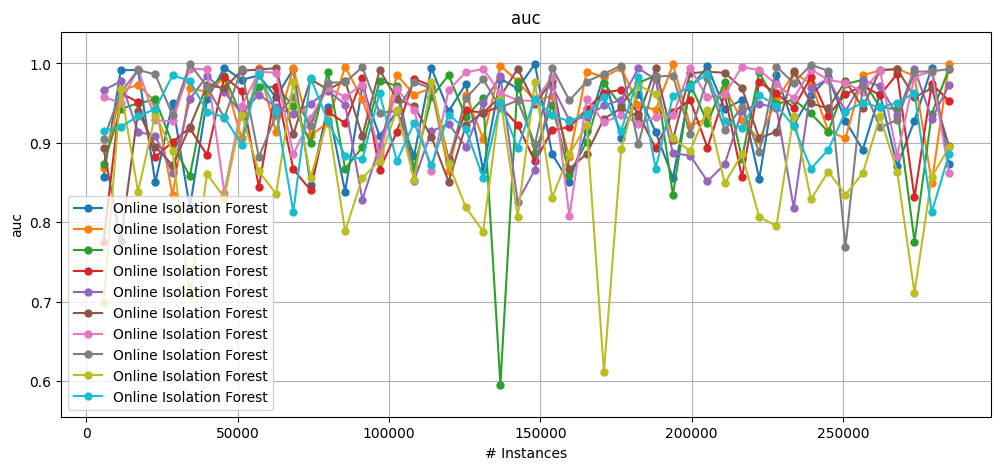

In [104]:
plot_windowed_results(*results_capy, metric="auc", save_only=False)